In [245]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
from pathlib import Path
from statsmodels.stats.multitest import multipletests

# Load data

In [246]:
data_folder = Path('../../../data')

In [247]:
sintef_fn = data_folder / 'this_project' / '1_e_coli_batch_cultures'/'1K_rates_and_values.csv'#'sintef_2023/sintef_2023_rates_1024.csv'

paczia_ecoli_fn = data_folder /'paczia_2012' / 'paczia_12_rates_ecoli.csv'
paczia_cglutamicum_fn =  data_folder /'paczia_2012' / 'paczia_12_rates_cglutamicum.csv'
paczia_yeast_fn =  data_folder /'paczia_2012' / 'paczia_12_rates_yeast.csv'
paczia_blicheniformis_fn = data_folder / 'paczia_2012' / 'paczia_12_rates_blicheniformis.csv'
vila_rates_fn = data_folder / 'vila_2023' / 'vila_2023_rates_and_values.csv'


In [248]:
sintef_df = pd.read_csv(sintef_fn, index_col=0)
paczia_df_ecoli = pd.read_csv(paczia_ecoli_fn, index_col = 0)
paczia_df_cglut = pd.read_csv(paczia_cglutamicum_fn, index_col = 0)
paczia_df_yeast = pd.read_csv(paczia_yeast_fn, index_col = 0)
paczia_df_blich = pd.read_csv(paczia_blicheniformis_fn, index_col = 0)
vila_df = pd.read_csv(vila_rates_fn, index_col=0)

In [249]:
paczia_df_ecoli.sort_values(by='Rate [mmol/gDW/h]', ascending=True)

,Metabolite abbrv.,Model ID,Metabolite,Metabolite value [gDW/mmol],MV min,MV max,Turnover [mmol/gDW/h],N carbons,Mol weight [g/mol],Rate [mmol/gDW/h],Std. Err [mmol/gDW/h],R2,p-value,Species,Carbon source,Dataset
15,GLU,glu__L,Glutamate,0.041525,0.031219,0.063595,6.284542,5,146.121320,-0.000004,1.015895e-04,0.000150,9.731776e-01,E. coli,Glucose,Paczia-12
36,TYR,tyr__L,Tyrosine,0.100410,0.080263,0.145860,0.086416,9,181.188540,0.000012,8.085400e-07,0.962918,5.248726e-07,E. coli,Glucose,Paczia-12
22,SER,ser__L,L-serine,0.059297,0.050082,0.060588,0.377084,3,105.092580,0.000012,2.556147e-06,0.738294,1.444044e-03,E. coli,Glucose,Paczia-12
24,MET,met__L,Methionine,0.239275,0.182804,0.269202,0.096718,5,149.211340,0.000012,8.498375e-07,0.968013,1.725148e-06,E. coli,Glucose,Paczia-12
17,GLY,gly,Glycine,0.045145,0.040603,0.047753,1.044095,2,75.066600,0.000013,6.549541e-06,0.328396,8.332932e-02,E. coli,Glucose,Paczia-12
27,PHE,phe__L,Phenylalanine,0.102466,0.081147,0.151364,0.115914,9,165.189140,0.000017,1.497406e-06,0.943323,2.887944e-06,E. coli,Glucose,Paczia-12
35,TRP,trp__L,Tryptophan,0.202368,0.202368,0.208556,0.035565,11,204.225180,0.000021,1.393149e-06,0.981951,1.229051e-04,E. coli,Glucose,Paczia-12
29,PRO,pro__L,Proline,0.056700,0.044988,0.081507,0.138307,5,115.130460,0.000031,4.968749e-06,0.883178,1.654738e-03,E. coli,Glucose,Paczia-12
10,E4P,e4p,Erythrose-4-phosphate,0.035542,0.025334,0.058855,0.238593,4,198.067941,0.000042,5.604872e-06,0.965425,1.743960e-02,E. coli,Glucose,Paczia-12
6,ASP,asp__L,Aspartate,0.030120,0.023227,0.044952,2.872589,4,132.094740,0.000053,2.580829e-06,0.981425,3.279920e-08,E. coli,Glucose,Paczia-12


In [250]:
df_rate = pd.concat([sintef_df, paczia_df_ecoli, paczia_df_cglut, paczia_df_blich,
          paczia_df_yeast, vila_df])
# df['Metabolite'] = df['Metabolite'].str.capitalize()

In [251]:
df_rate = df_rate[['Metabolite', 'Carbon source', 'Rate [mmol/gDW/h]',
       'Std. Err [mmol/gDW/h]', 'Metabolite value [gDW/mmol]', 'N carbons',
       'Mol weight [g/mol]', 'Turnover [mmol/gDW/h]', 'Species', 'Dataset']]

In [252]:
df_rate['Metabolite'] = df_rate['Metabolite'].replace({'L-serine': 'Serine', 
                                             # 'Propanoate': 'Propionate', 
                                             'Dihydroxyacetonephosphate': 'Dihydroxyacetone phosphate',
                                            'Deoxycarnitine (deoxy-c0)': 'Deoxycarnitine',
                                             'Glutarylcarnitine (c5-dc)': 'Glutarylcarnitine',
                                             'Sebacoyl-l-carnitine (c10-dc)': 'Sebacoyl-l-carnitine'})

df_rate.reset_index(inplace=True, drop=True)

## Any negative metabolite values?


In [253]:
(df_rate['Metabolite value [gDW/mmol]'] <0).sum()

np.int64(0)

In [254]:
mets = non_nan_mets = sorted(df_rate.Metabolite.unique())
non_nan_mets = sorted(df_rate.loc[~df_rate.isna().any(axis=1)].Metabolite.unique())


In [255]:
non_nan_mets

['2-phosphoglycerate',
 '3-phosphoglycerate',
 'Acetate',
 'Acetyl-ornithine',
 'Alanine',
 'Alpha-ketoglutarate',
 'Arginine',
 'Asparagine',
 'Aspartate',
 'Beta-alanine',
 'Beta-hydroxybutyrate',
 'Cis-aconitate',
 'Citrate',
 'Dihydroxyacetone phosphate',
 'Erythrose-4-phosphate',
 'Ethanol',
 'Formate',
 'Fructose-1,6-bisphosphate',
 'Fructose-6-phosphate',
 'Fumarate',
 'Gamma-aminobutyrate',
 'Glucose-6-phosphate',
 'Glutamate',
 'Glutamine',
 'Glyceraldehyde-3-phosphate',
 'Glycine',
 'Histidine',
 'Homoserine',
 'Isocitrate',
 'Isoleucine',
 'Lactate',
 'Leucine',
 'Lysine',
 'Malate',
 'Methionine',
 'NAD',
 'Orotate',
 'Oxaloacetate',
 'Phenylalanine',
 'Phosphoenolpyruvate',
 'Proline',
 'Propionate',
 'Putrescine',
 'Pyruvate',
 'Ribose-5-phosphate',
 'Ribulose-5-phosphate',
 'Sedoheptulose 7-phosphate',
 'Serine',
 'Shikimate',
 'Succinate',
 'Threonine',
 'Trans-aconitate',
 'Tryptophan',
 'Tyrosine',
 'Uracil',
 'Valine',
 'Xylulose-5-phosphate']

In [256]:
df_rate.notna().any(axis = 1)

0      True
1      True
2      True
3      True
4      True
       ... 
826    True
827    True
828    True
829    True
830    True
Length: 831, dtype: bool

# Load additional info

In [257]:
met_info_fn = data_folder / 'this_project' / '5_div' / '5C_metabolite_info.csv'

In [258]:
met_info = pd.read_csv(met_info_fn, index_col=0)

In [259]:
met_info.drop(columns=['Intracellular concentration [M]', 'Ref'], inplace=True)

In [260]:
df = df_rate.merge(met_info, left_on='Metabolite', right_on='Metabolite', how = 'outer')

In [261]:
# USe mol weight from pubchem
# df['Mol weight [g/mol]'] = df['Mass']
df.drop(columns=['Mass'], inplace=True)

# Get intracellular concentrations for E. coli

In [262]:
fn_i_conc = data_folder / 'this_project' / '4_paired_metabolomics_live_dead/4F_mapped_intracellular_conc.csv'
conditions_df = pd.read_csv(fn_i_conc, index_col=0)
conditions_df.dropna(inplace=True, subset=['Metabolite'])
conditions_df = conditions_df.loc[conditions_df['Phase'] == 'Exponential']



In [263]:
intracellular_metabolites = conditions_df.Metabolite.unique()

In [264]:
df.Species.unique()

array(['E. coli', 'C. glutamicum', 'B. licheniformis', 'S. cerevisiae',
       'Ecoli', 'Enterobacter', 'Pputida', 'Pseudomonas'], dtype=object)

In [265]:
for i, row in df.iterrows():
    if row['Species'] not in ['E. coli', 'Ecoli']:
        continue
    if row['Metabolite'] in intracellular_metabolites:
        cs = row['Carbon source'].capitalize()
        if cs == 'D-glucose':
            cs = 'Glucose'
        idx = (conditions_df.Metabolite == row['Metabolite'])&(conditions_df['Carbon source'] == cs)
        if np.sum(idx)>0:
            conc_uM = conditions_df.loc[idx, 'Intracellular concentration [uM]'].values[0]
        else:
            conc_uM = np.nan
        df.at[i, 'Intracellular concentration [uM]'] = conc_uM
        

    

## Calculate log-transformed values

In [266]:
df['log10(Rate [mmol/gDW/h])'] = np.log10(df['Rate [mmol/gDW/h]'])
df['log10(Metabolite value [gDW/mmol])'] = np.log10(df['Metabolite value [gDW/mmol]'])

/Users/snorre/miniconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [267]:
df['Rate [mmol C/gDW/h]'] = df['Rate [mmol/gDW/h]']*df['N carbons']
df['Rate [g/gDW/h]'] = df['Rate [mmol/gDW/h]']*df['Mol weight [g/mol]']*1e-3

df['Metabolite value [gDW/mmol C]'] = df['Metabolite value [gDW/mmol]']/df['N carbons']
df['Metabolite value [gDW/g]'] = df['Metabolite value [gDW/mmol]']*1e3/df['Mol weight [g/mol]']


In [268]:
cols = ['Rate [mmol C/gDW/h]', 'Rate [g/gDW/h]', 'Metabolite value [gDW/mmol C]', 'Metabolite value [gDW/g]', 'Turnover [mmol/gDW/h]']
for col in cols:
    logcol = f'log10({col})'
    df[logcol] = np.log10(df[col])

/Users/snorre/miniconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/snorre/miniconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/snorre/miniconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [269]:
df['Species - Carbon source'] = df['Species'] + ' - ' + df['Carbon source']

In [270]:
df['Intracellular concentration [M]'] = df['Intracellular concentration [uM]'] * 1e-6

## Save spreadsheet with rates to share

In [271]:
df.to_csv(data_folder / 'other'/ 'A_rates_and_values.csv')

In [272]:
rates_only_columns = ['Metabolite', 'Carbon source', 'Rate [mmol/gDW/h]',  'Species', 'Dataset',
       'Std. Err [mmol/gDW/h]','Rate [mmol C/gDW/h]','Rate [g/gDW/h]']
# df.loc[df.Species=='E. coli', rates_only_columns].to_csv('ecoli_rates.csv')

In [273]:
df.columns

Index(['Metabolite', 'Carbon source', 'Rate [mmol/gDW/h]',
       'Std. Err [mmol/gDW/h]', 'Metabolite value [gDW/mmol]', 'N carbons',
       'Mol weight [g/mol]', 'Turnover [mmol/gDW/h]', 'Species', 'Dataset',
       'Metabolite id', 'Charge', 'Phosphate', 'Compound class', 'Comment',
       'Hydrogen Bond Donor Count', 'Hydrogen Bond Acceptor Count',
       'Rotatable Bond Count', 'Topological Polar Surface Area',
       'Charge (pubchem)', 'xlogP', 'pubchem id', 'Formula',
       'Molecular weight [g/mol]', 'ECMDB name', 'ECMDB ID',
       'Park et al. name', 'Thorfinnsdottir et al. abbrv',
       'Intracellular concentration [uM]', 'log10(Rate [mmol/gDW/h])',
       'log10(Metabolite value [gDW/mmol])', 'Rate [mmol C/gDW/h]',
       'Rate [g/gDW/h]', 'Metabolite value [gDW/mmol C]',
       'Metabolite value [gDW/g]', 'log10(Rate [mmol C/gDW/h])',
       'log10(Rate [g/gDW/h])', 'log10(Metabolite value [gDW/mmol C])',
       'log10(Metabolite value [gDW/g])', 'log10(Turnover [mmol/g

In [274]:
df.loc[df.Species=='E. coli']['Carbon source'].unique()

array(['Galactose', 'L-malate', 'L-alanine', 'Glucose'], dtype=object)

# Print out information about estimated rates

In [275]:
datasets = df.Dataset.unique()
for d in datasets:
    dfd = df.loc[df.Dataset==d]
    carbon_sources = dfd['Carbon source'].unique()
    for cs in carbon_sources:
        nanidx = dfd['Rate [mmol/gDW/h]'].notna()
        dfdcs = dfd.loc[(dfd['Carbon source'] == cs) & nanidx]
        for s in dfdcs.Species.unique():
            dfdcs_s = dfdcs.loc[dfdcs['Species'] == s]
            if len(dfdcs_s) > 0:
                print(f'{d} - {cs} - {s}: {len(dfdcs_s)}')
                # print(dfdcs_s[['Metabolite', 'Rate [mmol/gDW/h]', 'Species', 'Carbon source', 'Dataset']])
                #
 


SINTEF-23 - Galactose - E. coli: 29
SINTEF-23 - L-malate - E. coli: 30
SINTEF-23 - L-alanine - E. coli: 35
Paczia-12 - Glucose - E. coli: 39
Paczia-12 - Glucose - C. glutamicum: 21
Paczia-12 - Glucose - B. licheniformis: 40
Paczia-12 - Glucose - S. cerevisiae: 28
Vila-23 - D-Glucose - Ecoli: 16
Vila-23 - D-Glucose - Enterobacter: 13
Vila-23 - D-Glucose - Pputida: 7
Vila-23 - D-Glucose - Pseudomonas: 9
Vila-23 - L-Malate - Ecoli: 14
Vila-23 - L-Malate - Enterobacter: 14
Vila-23 - L-Malate - Pputida: 12
Vila-23 - L-Malate - Pseudomonas: 13
Vila-23 - D-Fructose - Ecoli: 16
Vila-23 - D-Fructose - Enterobacter: 17
Vila-23 - D-Fructose - Pputida: 9
Vila-23 - D-Fructose - Pseudomonas: 11
Vila-23 - D-Galactose - Ecoli: 15
Vila-23 - D-Ribose - Ecoli: 14
Vila-23 - L-Arabinose - Ecoli: 13
Vila-23 - Glycerol - Ecoli: 13
Vila-23 - Glycerol - Enterobacter: 12
Vila-23 - Glycerol - Pputida: 10
Vila-23 - Glycerol - Pseudomonas: 11
Vila-23 - Pyruvate - Ecoli: 12
Vila-23 - Pyruvate - Enterobacter: 13
Vil

# Fraction of metabolite rates well described by a linear model of AUC
in Paczia

In [276]:
paczia_df_ecoli.columns

Index(['Metabolite abbrv.', 'Model ID', 'Metabolite',
       'Metabolite value [gDW/mmol]', 'MV min', 'MV max',
       'Turnover [mmol/gDW/h]', 'N carbons', 'Mol weight [g/mol]',
       'Rate [mmol/gDW/h]', 'Std. Err [mmol/gDW/h]', 'R2', 'p-value',
       'Species', 'Carbon source', 'Dataset'],
      dtype='object')

In [277]:
temp_df = paczia_df_ecoli.groupby('Metabolite abbrv.').agg({'R2':'first', 'p-value': 'first', 'Rate [mmol/gDW/h]':'first'}).reset_index()

In [278]:
print('E. coli')
strain_df_dict = {
    'E. coli': paczia_df_ecoli,
    'B. licheniformis': paczia_df_blich,
    'C. glutamicum': paczia_df_cglut,
    'S. cerevisiae': paczia_df_yeast
}
for strain, df in strain_df_dict.items():
    temp_df = df.groupby('Metabolite abbrv.').agg({'R2':'first', 'p-value': 'first', 'Rate [mmol/gDW/h]':'first'}).reset_index()
    not_na = temp_df['Rate [mmol/gDW/h]'].notna().sum()
    temp_df['adj. p-value'] = multipletests(temp_df['p-value'], method='fdr_bh')[1]
    idx_p_r2 = (temp_df['R2'] > 0.5) & (temp_df['p-value'] < 0.05)
    idx_padj_r2 = (temp_df['R2'] > 0.5) & (temp_df['adj. p-value'] < 0.05)
    significant_and_r2 = idx_p_r2.sum()
    print(f'Number of non-NaN rates for {strain}: {not_na}')
    print(f'Number of significant rates with R2 > 0.5 and P< 0.05 for {strain}: {significant_and_r2}')
    print('Fraction of significant rates with R2 > 0.5: {:.2f}'.format(significant_and_r2 / not_na) )
    print('')



E. coli
Number of non-NaN rates for E. coli: 37
Number of significant rates with R2 > 0.5 and P< 0.05 for E. coli: 33
Fraction of significant rates with R2 > 0.5: 0.89

Number of non-NaN rates for B. licheniformis: 37
Number of significant rates with R2 > 0.5 and P< 0.05 for B. licheniformis: 33
Fraction of significant rates with R2 > 0.5: 0.89

Number of non-NaN rates for C. glutamicum: 19
Number of significant rates with R2 > 0.5 and P< 0.05 for C. glutamicum: 18
Fraction of significant rates with R2 > 0.5: 0.95

Number of non-NaN rates for S. cerevisiae: 27
Number of significant rates with R2 > 0.5 and P< 0.05 for S. cerevisiae: 12
Fraction of significant rates with R2 > 0.5: 0.44



In [279]:
paczia_df_ecoli

,Metabolite abbrv.,Model ID,Metabolite,Metabolite value [gDW/mmol],MV min,MV max,Turnover [mmol/gDW/h],N carbons,Mol weight [g/mol],Rate [mmol/gDW/h],Std. Err [mmol/gDW/h],R2,p-value,Species,Carbon source,Dataset
0,23PG,2pg,2-phosphoglycerate,0.023198,0.016527,0.037230,12.219118,3,183.033421,0.000323,1.543375e-05,0.990963,1.830542e-09,E. coli,Glucose,Paczia-12
1,23PG,3pg,3-phosphoglycerate,0.023130,0.016431,0.037207,12.219118,3,183.033421,0.000323,1.543375e-05,0.990963,1.830542e-09,E. coli,Glucose,Paczia-12
2,ACT,ac,Acetate,0.009873,0.004352,0.021500,0.364498,2,59.044020,1.544754,1.880195e-01,0.918369,1.754611e-04,E. coli,Glucose,Paczia-12
3,ALA,ala__L,Alanine,0.023765,0.016822,0.038971,0.629622,3,89.093180,0.000100,1.156611e-05,0.913987,5.623168e-05,E. coli,Glucose,Paczia-12
4,AKG,akg,Alpha-ketoglutarate,0.036263,0.026843,0.056432,10.666347,5,144.082260,0.004123,1.454953e-03,0.889260,2.159708e-01,E. coli,Glucose,Paczia-12
5,ARG,arg__L,Arginine,0.115224,0.111323,0.118950,0.185067,6,175.208900,0.001903,2.019902e-04,0.946672,2.273629e-04,E. coli,Glucose,Paczia-12
6,ASP,asp__L,Aspartate,0.030120,0.023227,0.044952,2.872589,4,132.094740,0.000053,2.580829e-06,0.981425,3.279920e-08,E. coli,Glucose,Paczia-12
7,ACN,acon_C,Cis-aconitate,0.041368,0.030501,0.064215,6.022707,6,171.084420,0.000632,5.215580e-05,0.948308,1.994083e-06,E. coli,Glucose,Paczia-12
8,CIT,cit,Citrate,0.040849,0.029774,0.064041,6.022707,6,189.099700,0.006322,4.632948e-04,0.958805,8.007761e-07,E. coli,Glucose,Paczia-12
9,DHAP,dhap,Dihydroxyacetonephosphate,0.029999,0.022560,0.046249,6.136869,3,168.041961,0.001800,6.091113e-05,0.990922,1.863626e-09,E. coli,Glucose,Paczia-12


In [280]:
temp_df

,Metabolite abbrv.,R2,p-value,Rate [mmol/gDW/h],adj. p-value
0,ACT,0.950300,0.004775,0.285047,0.021485
1,AKG,0.629342,0.059666,0.001967,0.115994
2,ALA,0.217694,0.350920,0.000156,0.394786
3,ARG,0.043556,0.791299,-0.000881,0.791299
4,ASN,0.842417,0.009850,0.000064,0.033243
5,ASP,0.715731,0.033744,0.000011,0.091109
6,CIT,0.943716,0.152487,0.000610,0.226740
7,DHAP,0.963961,0.000493,0.000031,0.005175
8,ETH,0.992810,0.000019,8.002930,0.000525
9,F6P,0.960235,0.000601,0.000012,0.005175


In [281]:
temp_df

,Metabolite abbrv.,R2,p-value,Rate [mmol/gDW/h],adj. p-value
0,ACT,0.950300,0.004775,0.285047,0.021485
1,AKG,0.629342,0.059666,0.001967,0.115994
2,ALA,0.217694,0.350920,0.000156,0.394786
3,ARG,0.043556,0.791299,-0.000881,0.791299
4,ASN,0.842417,0.009850,0.000064,0.033243
5,ASP,0.715731,0.033744,0.000011,0.091109
6,CIT,0.943716,0.152487,0.000610,0.226740
7,DHAP,0.963961,0.000493,0.000031,0.005175
8,ETH,0.992810,0.000019,8.002930,0.000525
9,F6P,0.960235,0.000601,0.000012,0.005175


In [282]:
df_paczia = pd.concat([paczia_df_ecoli, paczia_df_cglut, paczia_df_blich,
          paczia_df_yeast])
df_meanp = df_paczia.groupby(['Metabolite abbrv.', 'Species']).mean(numeric_only=True).reset_index()
fraction_005 = (df_meanp['p-value']<0.05).sum()/df_meanp.shape[0]
print(f'Fraction of p-values < 0.05: {fraction_005:.2f}')
# df['Metabolite'] = df['Metabolite'].str.capitalize()
print(len(df_meanp), len(df_paczia))
# df_meanp.tail(20)
df_meanp['adj. p-value'] = multipletests(df_meanp['p-value'], method='fdr_bh')[1]

fraction_adj_005 = (df_meanp['adj. p-value']<0.05).sum()/df_meanp.shape[0]

print(f'Fraction of adjusted p-values < 0.05: {fraction_adj_005:.2f}')


Fraction of p-values < 0.05: 0.81
120 128
Fraction of adjusted p-values < 0.05: 0.78


In [283]:
df_paczia.loc[df_paczia['Species'] == 'S. cerevisiae']

,Metabolite abbrv.,Model ID,Metabolite,Metabolite value [gDW/mmol],MV min,MV max,Turnover [mmol/gDW/h],N carbons,Mol weight [g/mol],Rate [mmol/gDW/h],Std. Err [mmol/gDW/h],R2,p-value,Species,Carbon source,Dataset
0,ACT,s_0362,Acetate,0.000119,0.000119,0.000751,3.513848,2,59.044020,0.285047,0.037636,0.950300,0.004775,S. cerevisiae,Glucose,Paczia-12
1,ALA,s_0955,Alanine,0.003660,0.003385,0.003664,0.203462,3,89.093180,0.000156,0.000148,0.217694,0.350920,S. cerevisiae,Glucose,Paczia-12
2,AKG,s_0180,Alpha-ketoglutarate,0.009296,0.008661,0.009296,2.295749,5,144.082260,0.001967,0.000755,0.629342,0.059666,S. cerevisiae,Glucose,Paczia-12
3,ARG,s_0965,Arginine,0.104217,0.101482,0.104217,0.071265,6,175.208900,-0.000881,0.002919,0.043556,0.791299,S. cerevisiae,Glucose,Paczia-12
4,ASN,s_0969,Asparagine,0.056095,0.054956,0.056097,0.045101,4,132.117920,0.000064,0.000014,0.842417,0.009850,S. cerevisiae,Glucose,Paczia-12
5,ASP,s_0973,Aspartate,0.009769,0.009767,0.009863,0.564109,4,132.094740,0.000011,0.000004,0.715731,0.033744,S. cerevisiae,Glucose,Paczia-12
6,CIT,s_0522,Citrate,0.010610,0.009875,0.010610,0.119386,6,189.099700,0.000610,0.000149,0.943716,0.152487,S. cerevisiae,Glucose,Paczia-12
7,DHAP,s_0629,Dihydroxyacetonephosphate,0.006537,0.006537,0.008743,7.464696,3,168.041961,0.000031,0.000003,0.963961,0.000493,S. cerevisiae,Glucose,Paczia-12
8,ETH,s_0680,Ethanol,0.000587,0.000585,0.001046,4.220738,2,46.068440,8.002930,0.340528,0.992810,0.000019,S. cerevisiae,Glucose,Paczia-12
9,FBP,s_0555,"Fructose-1,6-bisphosphate",0.012645,0.012645,0.017089,0.000000,6,340.115682,0.000467,0.000158,0.686071,0.041693,S. cerevisiae,Glucose,Paczia-12


In [284]:
df_paczia.head()

,Metabolite abbrv.,Model ID,Metabolite,Metabolite value [gDW/mmol],MV min,MV max,Turnover [mmol/gDW/h],N carbons,Mol weight [g/mol],Rate [mmol/gDW/h],Std. Err [mmol/gDW/h],R2,p-value,Species,Carbon source,Dataset
0,23PG,2pg,2-phosphoglycerate,0.023198,0.016527,0.037230,12.219118,3,183.033421,0.000323,0.000015,0.990963,1.830542e-09,E. coli,Glucose,Paczia-12
1,23PG,3pg,3-phosphoglycerate,0.023130,0.016431,0.037207,12.219118,3,183.033421,0.000323,0.000015,0.990963,1.830542e-09,E. coli,Glucose,Paczia-12
2,ACT,ac,Acetate,0.009873,0.004352,0.021500,0.364498,2,59.044020,1.544754,0.188019,0.918369,1.754611e-04,E. coli,Glucose,Paczia-12
3,ALA,ala__L,Alanine,0.023765,0.016822,0.038971,0.629622,3,89.093180,0.000100,0.000012,0.913987,5.623168e-05,E. coli,Glucose,Paczia-12
4,AKG,akg,Alpha-ketoglutarate,0.036263,0.026843,0.056432,10.666347,5,144.082260,0.004123,0.001455,0.889260,2.159708e-01,E. coli,Glucose,Paczia-12


In [285]:
df.loc[df.Dataset=='Paczia-12'].head()


,Metabolite abbrv.,Model ID,Metabolite,Metabolite value [gDW/mmol],MV min,MV max,Turnover [mmol/gDW/h],N carbons,Mol weight [g/mol],Rate [mmol/gDW/h],Std. Err [mmol/gDW/h],R2,p-value,Species,Carbon source,Dataset
0,ACT,s_0362,Acetate,0.000119,0.000119,0.000751,3.513848,2,59.04402,0.285047,0.037636,0.950300,0.004775,S. cerevisiae,Glucose,Paczia-12
1,ALA,s_0955,Alanine,0.003660,0.003385,0.003664,0.203462,3,89.09318,0.000156,0.000148,0.217694,0.350920,S. cerevisiae,Glucose,Paczia-12
2,AKG,s_0180,Alpha-ketoglutarate,0.009296,0.008661,0.009296,2.295749,5,144.08226,0.001967,0.000755,0.629342,0.059666,S. cerevisiae,Glucose,Paczia-12
3,ARG,s_0965,Arginine,0.104217,0.101482,0.104217,0.071265,6,175.20890,-0.000881,0.002919,0.043556,0.791299,S. cerevisiae,Glucose,Paczia-12
4,ASN,s_0969,Asparagine,0.056095,0.054956,0.056097,0.045101,4,132.11792,0.000064,0.000014,0.842417,0.009850,S. cerevisiae,Glucose,Paczia-12


# Plot!

In [286]:
df['Growth impact'] = df['Metabolite value [gDW/mmol]']*df['Rate [mmol/gDW/h]']

In [287]:
df.sort_values(by = 'Growth impact', ascending = False, inplace = True)

In [288]:
datasets = df.Dataset.unique()
for d in datasets:
    for cs in df['Carbon source'].unique():
        for s in df['Species'].unique():
            dfd = df.loc[(df['Dataset'] == d) & (df['Carbon source'] == cs) & (df['Species'] == s)]
            if len(dfd) > 0:
                total_impact = dfd.loc[dfd['Rate [mmol/gDW/h]'] > 0, 'Growth impact'].sum()
                print(d, cs, s, total_impact)    #
                # print(dfd.loc[dfd['Rate [mmol/gDW/h]'] > 0, ['Metabolite', 'Rate [mmol/gDW/h]', 'Metabolite value [gDW/mmol]',
                                                            #  'Growth impact', 
                                                            #   'Species', 'Carbon source', 'Dataset']])

Paczia-12 Glucose S. cerevisiae 0.004957776885051249


In [289]:
df[['Metabolite', 'Rate [mmol/gDW/h]', 'Species', 'Carbon source', 'Dataset', 'Growth impact', 'Metabolite value [gDW/mmol]']].head(20)

,Metabolite,Rate [mmol/gDW/h],Species,Carbon source,Dataset,Growth impact,Metabolite value [gDW/mmol]
8,Ethanol,8.002930,S. cerevisiae,Glucose,Paczia-12,4.696744e-03,0.000587
26,Uracil,0.000456,S. cerevisiae,Glucose,Paczia-12,7.347876e-05,0.161073
20,Orotate,0.001043,S. cerevisiae,Glucose,Paczia-12,4.374895e-05,0.041934
0,Acetate,0.285047,S. cerevisiae,Glucose,Paczia-12,3.389903e-05,0.000119
22,Proline,0.000930,S. cerevisiae,Glucose,Paczia-12,2.442200e-05,0.026271
18,Lysine,0.000145,S. cerevisiae,Glucose,Paczia-12,2.376700e-05,0.163721
2,Alpha-ketoglutarate,0.001967,S. cerevisiae,Glucose,Paczia-12,1.828352e-05,0.009296
24,Succinate,0.002550,S. cerevisiae,Glucose,Paczia-12,1.333668e-05,0.005230
6,Citrate,0.000610,S. cerevisiae,Glucose,Paczia-12,6.476693e-06,0.010610
9,"Fructose-1,6-bisphosphate",0.000467,S. cerevisiae,Glucose,Paczia-12,5.908484e-06,0.012645


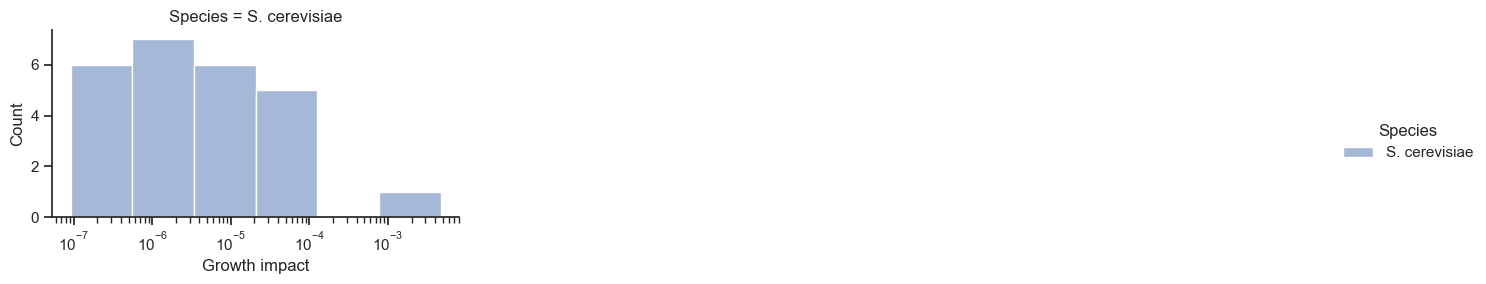

In [290]:
sns.displot(data = df, 
            x = 'Growth impact', col = 'Species', hue = 'Species', fill = True, common_norm = False, kind = 'hist',
            log_scale=True,col_wrap=3, height=3, aspect=1.5,)